In [2]:
import tensorflow as tf

In [3]:
from data.dataloader import tf_data_generator
from models.losses import tf_loss_function_mat

In [4]:
from models.gru_denoiser import BiGRUSpectralDenoiserTensorFlow

In [5]:
from training.trainer import Trainer_tf

In [6]:
from estimator.QIS import tf_QIS_batched

In [7]:
import numpy as np
import matplotlib.pyplot as plt

## NN

In [8]:
def frobenius_mean(A, B):
    A = tf.cast(A, tf.float32)
    B = tf.cast(B, tf.float32)
    diff = A - B
    frob_per_batch = tf.sqrt(tf.reduce_sum(tf.square(diff), axis=[1,2]))
    return tf.reduce_mean(frob_per_batch)

In [9]:
def mse(A, B):
    A = tf.cast(A, tf.float32)
    B = tf.cast(B, tf.float32)
    return tf.reduce_mean(tf.square(A - B))

In [10]:
N_min = 70
N_max = 250
T_min = 30
T_max = 70
batch_size=100

### Training loop — Generated Data

In [11]:
model_generated_data = BiGRUSpectralDenoiserTensorFlow(hidden_size=96) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

In [12]:
trainer = Trainer_tf(
    model=model_generated_data, is_train_on_real_data = False, loss_function=tf_loss_function_mat, data_generator=tf_data_generator, lr = 1e-4, weight_decay=1e-5,
    batch_size=batch_size, epochs=30, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, log_interval=10, accumulate_steps=2, dataset=None, missing_constant = 2,
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses = trainer.train()

Starting training for 30 epochs…
Epoch 10/30 — loss: 0.01549801
Epoch 20/30 — loss: 0.01999173
Epoch 30/30 — loss: 0.02250405
Training complete.


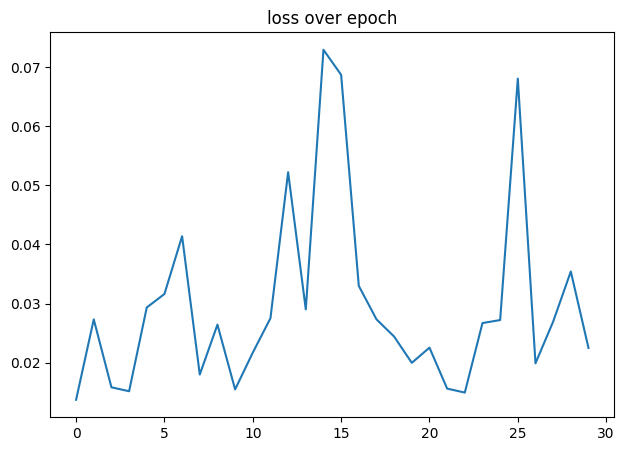

In [13]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

### Comparaison (oos)

In [14]:
batch_size_oos = 500

In [34]:
input_seq_cov_miss, Q_emp_miss, Sigma_true_miss, T, Sigma_hat_diag_miss, R_miss          = next(tf_data_generator(batch_size_oos, missing_constant = 2, N_min=60, N_max=60, T_min=60, T_max=60))
input_seq_cov_no_miss, Q_emp_no_miss, Sigma_true_no_miss, T, Sigma_hat_diag_no_miss, R_no_miss = next(tf_data_generator(batch_size_oos, missing_constant = 1, N_min=60, N_max=60, T_min=60, T_max=60))

In [35]:
R_miss.shape

TensorShape([500, 60, 60])

In [36]:
(~np.isnan(R_miss.numpy())).all(axis=1).sum(axis=-1)

array([30, 30, 30, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 31, 30, 30, 31, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30,
       30, 31, 30, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 31, 30, 30, 30,
       30, 30, 32, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 33, 30, 30, 30, 31, 30, 31, 30, 30,
       30, 30, 30, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 31, 30, 30,
       30, 31, 30, 30, 30, 30, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 31, 30,
       30, 30, 31, 30, 30, 30, 31, 31, 30, 30, 30, 30, 30, 30, 31, 30, 30,
       31, 30, 30, 30, 30, 30, 30, 30, 31, 30, 30, 30, 31, 30, 30, 30, 31,
       30, 30, 30, 30, 30

In [37]:
R_miss.shape

TensorShape([500, 60, 60])

In [38]:
R_miss[:,:,-15:].shape

TensorShape([500, 60, 15])

In [39]:
T

60

In [40]:
lam_emp_miss     = input_seq_cov_miss[:,:,0]
lam_pred_miss    = model_generated_data(input_seq_cov_miss) # ,lam_emp_miss
lam_emp_no_miss  = input_seq_cov_no_miss[:,:,0]
lam_pred_no_miss = model_generated_data(input_seq_cov_no_miss) # ,lam_emp_no_miss

Comparaison matrix $Corr$

In [41]:
# Corr from predicted eigenvalues
Corr_pred_miss = tf.matmul( tf.matmul(Q_emp_miss, tf.linalg.diag(lam_pred_miss)), Q_emp_miss, transpose_b=True)
Corr_pred_no_miss = tf.matmul(tf.matmul(Q_emp_no_miss, tf.linalg.diag(lam_pred_no_miss)),Q_emp_no_miss, transpose_b=True)

# Corr from empirical eigenvalues
Corr_emp_miss = tf.matmul(tf.matmul(Q_emp_miss, tf.linalg.diag(lam_emp_miss)),Q_emp_miss,transpose_b=True)
Corr_emp_no_miss = tf.matmul(tf.matmul(Q_emp_no_miss, tf.linalg.diag(lam_emp_no_miss)),Q_emp_no_miss,transpose_b=True)

In [42]:
# MISS
diag_oos_miss = tf.linalg.diag_part(Sigma_true_miss)
std_oos_miss = tf.sqrt(tf.maximum(diag_oos_miss, 1e-12))
Corr_true_miss = Sigma_true_miss / (
    std_oos_miss[:, None, :] * std_oos_miss[:, :, None] + 1e-12
)

# NO MISS
diag_oos_no_miss = tf.linalg.diag_part(Sigma_true_no_miss)
std_oos_no_miss = tf.sqrt(tf.maximum(diag_oos_no_miss, 1e-12))
Corr_true_no_miss = Sigma_true_no_miss / (
    std_oos_no_miss[:, None, :] * std_oos_no_miss[:, :, None] + 1e-12
)

In [43]:
Corr_pred_miss.shape

TensorShape([500, 60, 60])

In [44]:
fro_Corr_pred_miss    = frobenius_mean(Corr_pred_miss, Corr_true_miss)
fro_Corr_pred_no_miss = frobenius_mean(Corr_pred_no_miss, Corr_true_no_miss)
fro_Corr_emp_miss     = frobenius_mean(Corr_emp_miss, Corr_true_miss)
fro_Corr_emp_no_miss  = frobenius_mean(Corr_emp_no_miss, Corr_true_no_miss)

In [45]:
print(f"MSE Corr after miss + NN:         {fro_Corr_pred_miss.numpy():.6f}")
print(f"MSE Corr after no miss + NN :     {fro_Corr_pred_no_miss.numpy():.6f}")
print(f"MSE Corr after miss + no NN :     {fro_Corr_emp_miss.numpy():.6f}")
print(f"MSE Corr after no miss  + no NN : {fro_Corr_emp_no_miss.numpy():.6f}")

MSE Corr after miss + NN:         6.518966
MSE Corr after no miss + NN :     6.665533
MSE Corr after miss + no NN :     9.563091
MSE Corr after no miss  + no NN : 7.625715


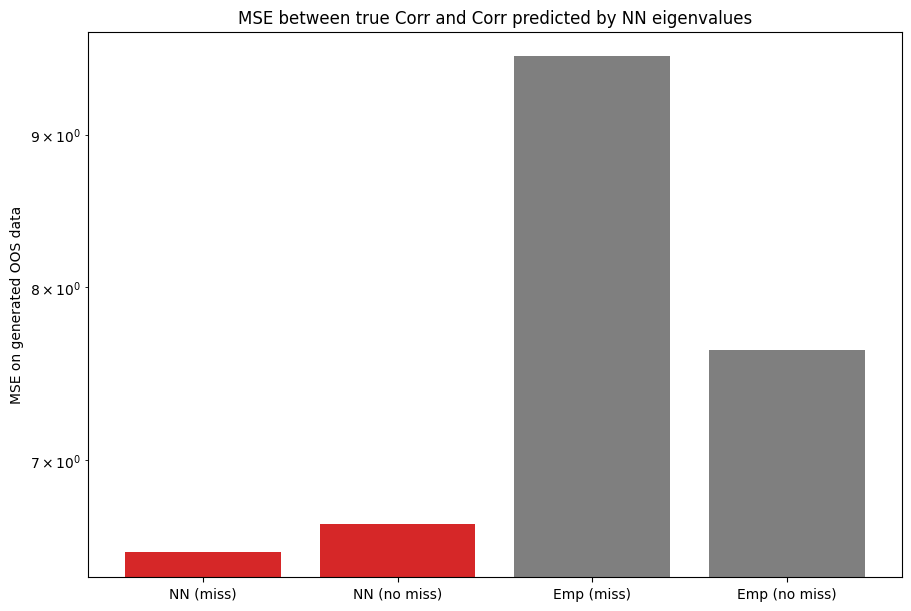

In [46]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [
    fro_Corr_pred_miss.numpy(),
    fro_Corr_pred_no_miss.numpy(),
    fro_Corr_emp_miss.numpy(),
    fro_Corr_emp_no_miss.numpy(),
]

colors = ['tab:red','tab:red','tab:gray','tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Corr and Corr predicted by NN eigenvalues")
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()

In [47]:
D_miss = tf.cast(tf.sqrt(tf.linalg.diag(Sigma_hat_diag_miss)), tf.float32)
D_no_miss = tf.cast(tf.sqrt(tf.linalg.diag(Sigma_hat_diag_no_miss)), tf.float32)

Corr_pred_miss = tf.cast(Corr_pred_miss, tf.float32)
Corr_pred_no_miss = tf.cast(Corr_pred_no_miss, tf.float32)
Corr_emp_miss = tf.cast(Corr_emp_miss, tf.float32)
Corr_emp_no_miss = tf.cast(Corr_emp_no_miss, tf.float32)

Sigma_pred_miss = tf.matmul(tf.matmul(D_miss, Corr_pred_miss), D_miss)
Sigma_pred_no_miss = tf.matmul(tf.matmul(D_no_miss, Corr_pred_no_miss), D_no_miss)
Sigma_emp_miss = tf.matmul(tf.matmul(D_miss, Corr_emp_miss), D_miss)
Sigma_emp_no_miss = tf.matmul(tf.matmul(D_no_miss, Corr_emp_no_miss), D_no_miss)

In [48]:
Sigma_QIS = tf_QIS_batched(R_miss[:,:,-3:])

In [49]:
R_miss[0,:,-30:].shape


TensorShape([60, 30])

In [50]:
fro_Sigma_pred_miss    = frobenius_mean(Sigma_pred_miss, Sigma_true_miss)
fro_Sigma_pred_no_miss = frobenius_mean(Sigma_pred_no_miss, Sigma_true_no_miss)
fro_Sigma_emp_miss     = frobenius_mean(Sigma_emp_miss, Sigma_true_miss)
fro_Sigma_emp_no_miss  = frobenius_mean(Sigma_emp_no_miss, Sigma_true_no_miss)
fro_Sigma_QIS          = frobenius_mean(Sigma_QIS, Sigma_true_no_miss)

In [51]:
print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss.numpy():.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss.numpy():.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss.numpy():.6f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss.numpy():.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS.numpy():.6f}")

MSE Sigma after miss + NN:         6.948079
MSE Sigma after no miss + NN :     7.004241
MSE Sigma after miss + no NN :     9.895465
MSE Sigma after no miss  + no NN : 7.903998
MSE Sigma QIS :                    7.627462


/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_2214/132896052.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


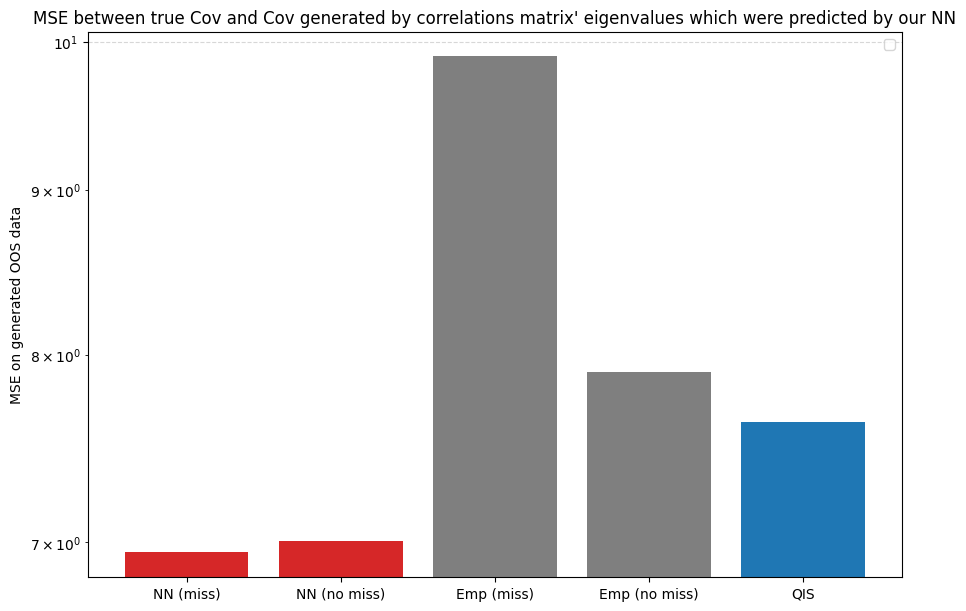

In [52]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)', 'QIS']# 'projected Em (miss)' 'projected Em (no miss)']
values = [fro_Sigma_pred_miss.numpy(), fro_Sigma_pred_no_miss.numpy(), fro_Sigma_emp_miss.numpy(), fro_Sigma_emp_no_miss.numpy(), fro_Sigma_QIS.numpy()]# fro_Sigma_near_miss.item(), fro_Sigma_near_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray', 'tab:blue']#,, 'tab:gray''tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Cov and Cov generated by correlations matrix' eigenvalues which were predicted by our NN")
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()
